# ICT4SM lab 3 - group 14

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df=pd.read_csv("Unipol_dataset_lab3.csv")

## Preliminary Analysis

In [19]:
df

,Unnamed: 0,vehicle_id,trip_id,start_time,stop_time,road,total_distance
0,0,1,0,2023-09-29 13:55:35,2023-09-29 14:11:42,E,14.31
1,1,1,0,2023-09-29 13:55:35,2023-09-29 14:11:42,U,1.47
2,2,1,1,2023-09-29 14:32:24,2023-09-29 14:34:31,U,0.03
3,3,1,2,2023-09-29 15:12:03,2023-09-29 15:26:55,E,2.60
4,4,1,2,2023-09-29 15:12:03,2023-09-29 15:26:55,U,2.00
...,...,...,...,...,...,...,...
1415300,1415300,1000,474,2023-11-28 13:15:02,2023-11-28 13:36:51,U,0.52
1415301,1415301,1000,475,2023-11-28 14:49:22,2023-11-28 15:09:03,U,0.00
1415302,1415302,1000,476,2023-11-28 15:16:18,2023-11-28 15:18:11,U,0.00
1415303,1415303,1000,477,2023-11-28 15:18:31,2023-11-28 15:28:41,U,0.00


### Distribution of trip distance of different types of roads

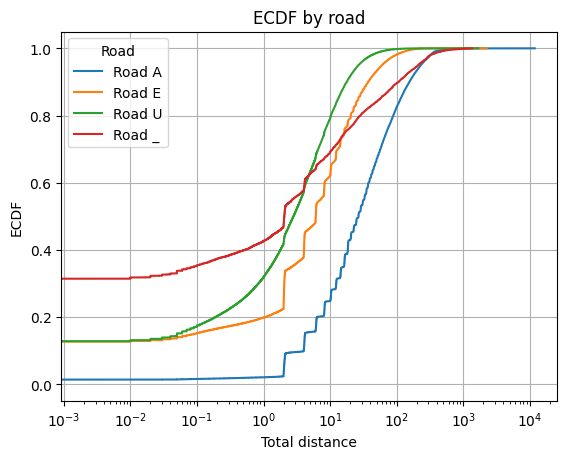

In [42]:
for road, group in df.groupby('road'):
    
    x = np.sort(group['total_distance'])
    y = np.arange(1, len(x) + 1) / len(x) # Calculate cumulated probabilities 
    
    plt.step(x, y, label=f'Road {road}')

plt.xscale('log')
plt.xlabel('Total distance')
plt.ylabel('ECDF')
plt.title('ECDF by road')
plt.legend(title='Road')
plt.grid()
plt.show()

- Road A : Highwaw
- Road E : Extra-Urban
- Road U : Urban

Highway trips rise slower than Urban or extraurban trips showing that user taking the highway tend to go further with their car, indicating longer trips, as could be expected with the use of highways. The fastest rise of Urban ECDF compared to Extra-Urban is also coherent with a use within a smaller zone (the city) with shorter distances.

### Distribution of trip duration

C:\Users\sartr\AppData\Local\Temp\ipykernel_8012\3483215745.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trip_durations = df.groupby('trip_id').apply(


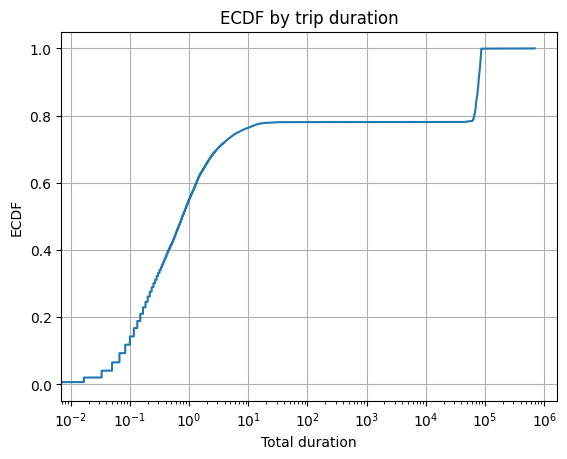

In [53]:
df['start_time'] = pd.to_datetime(df['start_time'])
df['stop_time'] = pd.to_datetime(df['stop_time'])

trip_durations = df.groupby('trip_id').apply(
    lambda group: (group['stop_time'].max() - group['start_time'].min()).total_seconds() / 60
).reset_index(name='durations')

x = np.sort(trip_durations['durations'])
y = np.arange(1, len(x) + 1) / len(x)

plt.plot(x,y)
plt.xscale('log')
plt.xlabel('Total duration')
plt.ylabel('ECDF')
plt.title('ECDF by trip duration')
plt.grid()
plt.show()

Some surprisingly high values, even though 80% are below 100s trip (around one and a half hour) we see some anormally long trips, up to 10**5 seconds which is a visible outlier. There also are some too short trips.

### Relationship between trip duration and distance

There is indeed a relationship between trip duration and distance : speed. Speed = distance/duration. For a same trip on different roads, we should see different speed. 

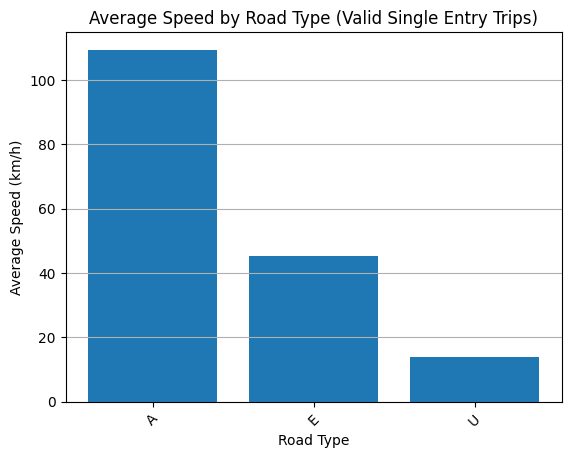

In [63]:
# Eliminate trips that have various roads
once_trips = df.groupby('trip_id').filter(lambda group: len(group) == 1)

once_trips['start_time'] = pd.to_datetime(once_trips['start_time'])
once_trips['stop_time'] = pd.to_datetime(once_trips['stop_time'])

once_trips['duration_hours'] = (once_trips['stop_time'] - once_trips['start_time']).dt.total_seconds() / 3600 # Duration of the trip

once_trips['speed_kmh'] = once_trips['total_distance'] / once_trips['duration_hours'] # Calculate the speed of the trip

valid_trips = once_trips[once_trips['duration_hours'] >= 0.02] # Eliminating too short trips (that give too high speed)

average_speed_by_road = valid_trips.groupby('road')['speed_kmh'].mean().reset_index() # Calculating the average speed


plt.bar(average_speed_by_road['road'], average_speed_by_road['speed_kmh'])

plt.xlabel('Road Type')
plt.ylabel('Average Speed (km/h)')
plt.title('Average Speed by Road Type (Valid Single Entry Trips)')
plt.xticks(rotation=45)  # Rotate road type labels if necessary
plt.grid(axis='y')

# Show the plot
plt.show()



We eliminated the too short trips (duration < 0.02 sec) because they gave too high speeds and incorrect representation and the trips that had been made on different roads, since the speed would change but we have only the global time of the trip. We therefore see that we indeed have a higher speed on highways than in extra urban that itself has greater speed than urban. The speed values are even relatively coherent with known speed in these roads, maybe a bit too fast on highway and too slow elsewhere.

### How many valid trips are recorded in the dataset?

We can delete trips that are : 
- Under 5 minutes and longer than 10 hours
- Require a speed more than one and a half over the average speed on their road (unfeasible trips)
- Have a total distance under 1 km
- Occured on an unknown road

In [ ]:
df=pd.read_csv("Unipol_dataset_lab3.csv")
old = df.shape[0]
print(f"Initial total number of trips: {old}")

# Duration in hours and speed
df['start_time'] = pd.to_datetime(df['start_time'])
df['stop_time'] = pd.to_datetime(df['stop_time'])
df['duration_hours'] = (df['stop_time'] - df['start_time']).dt.total_seconds() / 3600
df['speed'] = df['total_distance'] / df['duration_hours']

road_speed = df.groupby('road')['speed'].mean().reset_index(name='average_speed') # Group by road and calculate the average speed

df = pd.merge(df, road_speed, on='road', how='left') # Merge the average speed back into the original DataFrame

df = df[df['speed'] <= 1.5 * df['average_speed']] # Trips with speed <= 1.5 * average road speed

df = df[df['total_distance'] >= 1] # Trips with total distance >= 1 km

df = df[df['road'] != 'unknown'] # Trips on unknown roads

new = df.shape[0]
percentage = (new - old ) / old * 100
# Debug: Check the final DataFrame
print(f"Total number of valid trips: {new}")
print(f"Percentage of decreasing: {percentage}")


Initial total number of trips: 1415305
Total number of valid trips: 1054915
Percentage of decreasing: -25.4637692935445


# Tasks

## 1. Analysing behaviours of vehicles